##### These imports set up the basic environment

In [ ]:

import numpy as np
import pandas as pd
import os


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2

# Imports MobileNetV2 (pretrained CNN model) and images process tools

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Preparing Dataset paths and lables

import os
import pandas as pd
DIR = '/content/drive/MyDrive/fish_classification_project/data/Fish_Dataset'

classes = [i for i in os.listdir(DIR) if '.' not in i]
print("Classes found:", classes)

label = []
path = []

for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dirname.split('/')[-1] != 'GT':
                label.append(os.path.basename(dirname))
                path.append(os.path.join(dirname, filename))
df = pd.DataFrame({'path': path, 'label': label})
df.head()


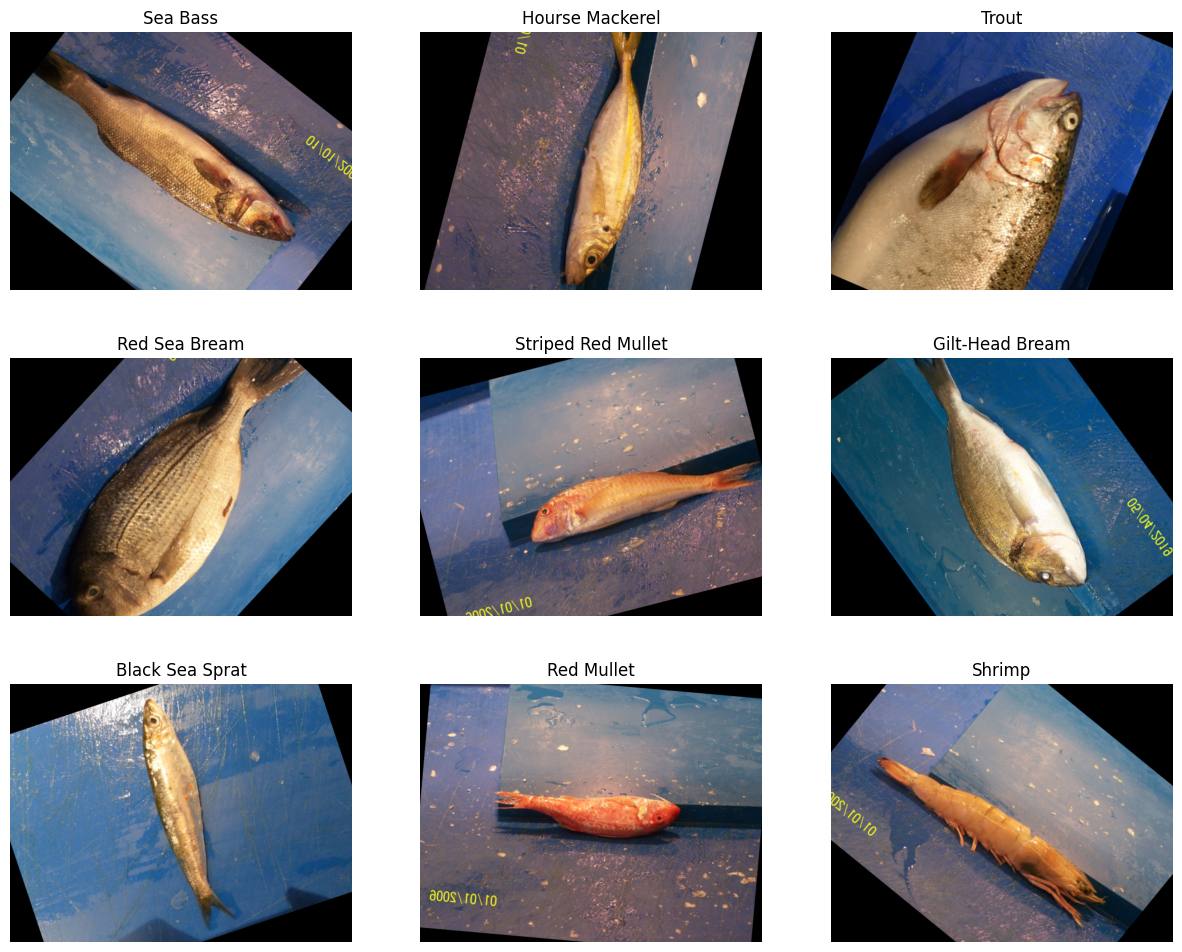

In [ ]:
# Display images from each classes

idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [ ]:
# Split dataset into 80% train , 20% set 

train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


In [ ]:
# Use ImageDataGenerator for preprocessing adn augmentation

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

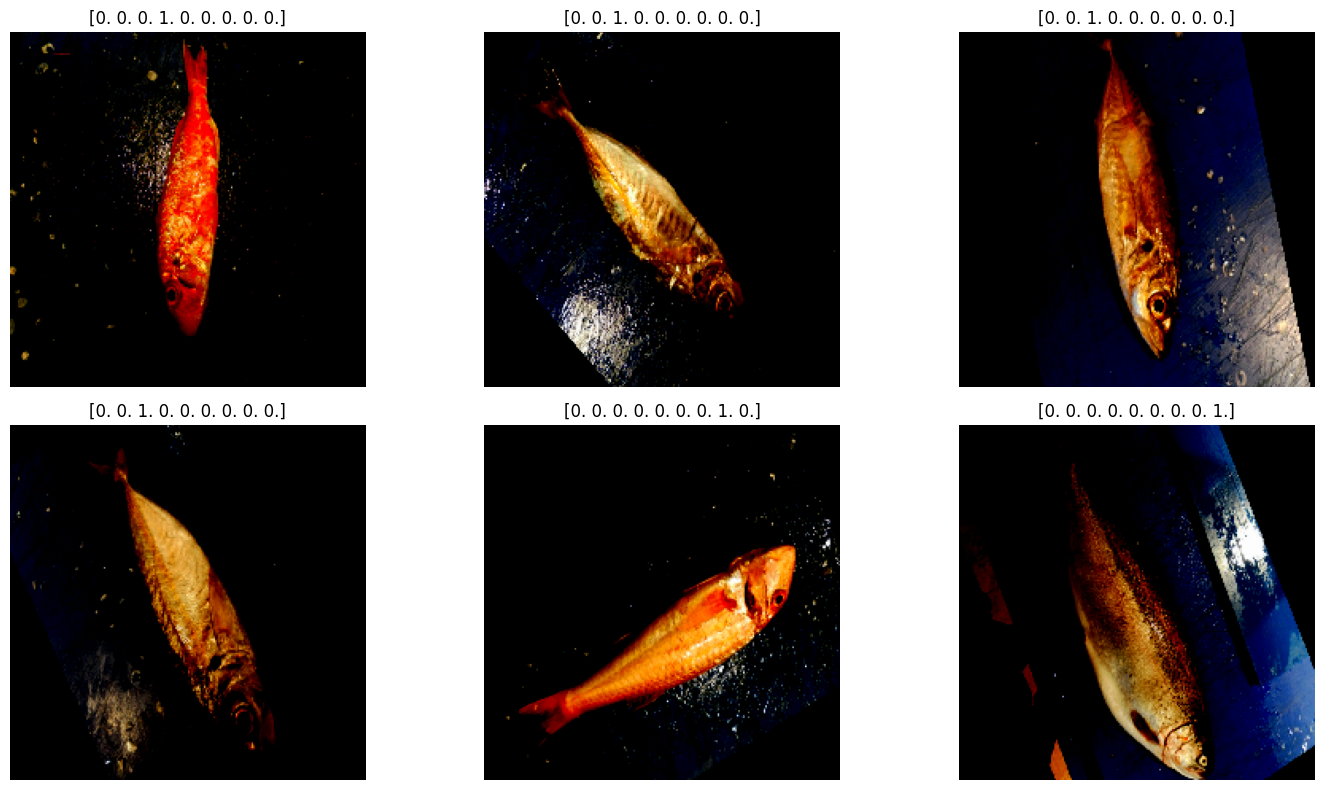

In [ ]:
# Display a few test images to verify preprocessing 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

for j in range(6):
    img, label = next(test_images)
    ax[j].imshow(img[0])
    ax[j].set_title(label[0])
    ax[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#  Used MobileNetV2 as feature extractor (ImageNet pretrained)

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00402
Test Accuracy: 100.00%


In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet,Red Mullet
1,/content/Fish_Dataset/Fish_Dataset/Hourse Mack...,Hourse Mackerel,Hourse Mackerel
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet,Striped Red Mullet
4,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
5,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
6,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream,Gilt-Head Bream
7,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
8,/content/Fish_Dataset/Fish_Dataset/Red Sea Bre...,Red Sea Bream,Red Sea Bream
9,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet,Striped Red Mullet


In [ ]:
pred_df[pred_df['label']!=pred_df['pred']]

,path,label,pred


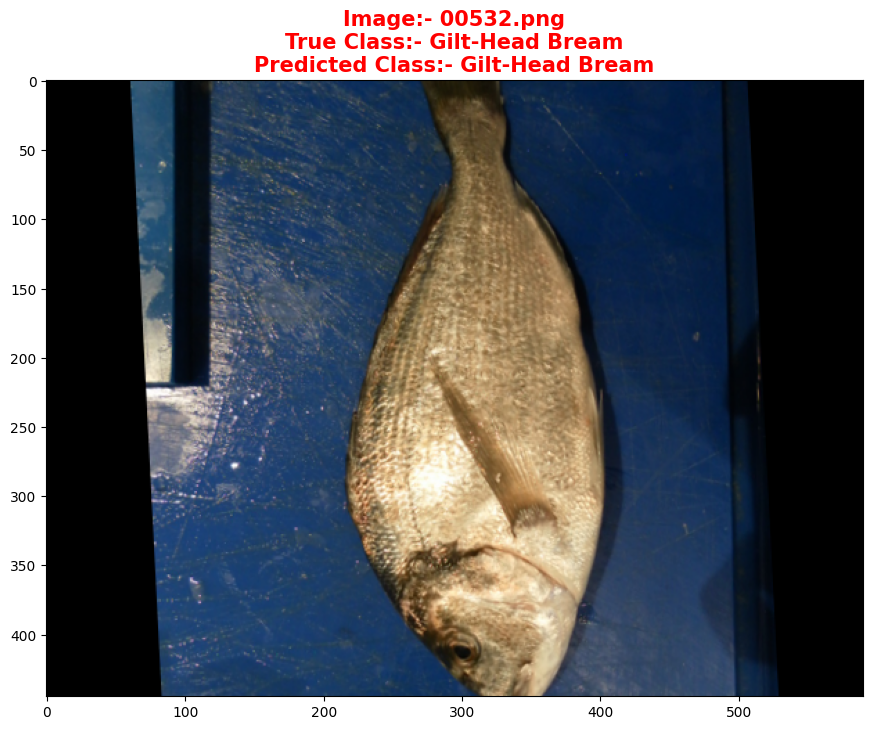

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1604]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [ ]:
print(classification_report(pred_df['label'],pred_df['pred']))

In [ ]:
df['label'].value_counts()

,count
label,
Sea Bass,1000
Hourse Mackerel,1000
Trout,1000
Red Sea Bream,1000
Striped Red Mullet,1000
Gilt-Head Bream,1000
Black Sea Sprat,1000
Red Mullet,1000
Shrimp,1000


In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

print("Compiled successfully with optimizer=adam, loss=categorical_crossentropy, metrics=['accuracy']\n")

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=80)


loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss,val_loss,accuracy,val_accuracy


Model: "functional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]      0         
 mobilenetv2_1.00_224 (Functional)  (None, 7, 7, 1280)  3257984  
 dense (Dense)               (None, 128)                163968    
 dense_1 (Dense)             (None, 128)                16512     
 dense_2 (Dense)             (None, 9)                  1161      
Total params: 3,438,625
Trainable params: 3,404,513
Non-trainable params: 34,112
_________________________________________________________________

Compiled successfully with optimizer=adam, loss=categorical_crossentropy, metrics=['accuracy']

Epoch 1/80
   - loss: 0.6025 - accuracy: 0.4065 - val_loss: 0.6493 - val_accuracy: 0.4000
Epoch 2/80
   - loss: 0.5583 - accuracy: 0.4619 - val_loss: 0.6079 - val_accuracy: 0.4282
Epoch 3/80
   - loss: 0.5193 - accuracy: 0.4841 - val_loss: 0.5735 - val_accuracy: 0.4537


In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00402
Test Accuracy: 100.00%


In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet,Red Mullet
1,/content/Fish_Dataset/Fish_Dataset/Hourse Mack...,Hourse Mackerel,Hourse Mackerel
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet,Striped Red Mullet
4,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
5,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
6,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream,Gilt-Head Bream
7,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp,Shrimp
8,/content/Fish_Dataset/Fish_Dataset/Red Sea Bre...,Red Sea Bream,Red Sea Bream
9,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet,Striped Red Mullet


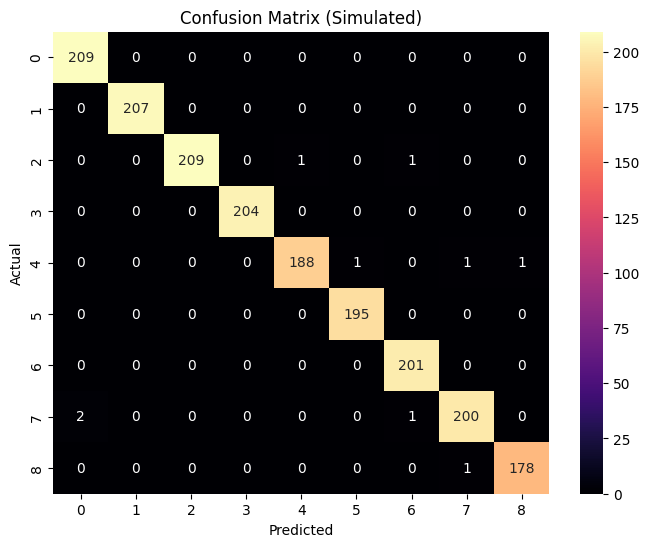

              precision  recall  f1-score  support
0                  0.99    1.00      1.00    209.0
1                  1.00    1.00      1.00    207.0
2                  1.00    0.99      1.00    211.0
3                  1.00    1.00      1.00    204.0
4                  0.99    0.98      0.99    191.0
5                  0.99    1.00      1.00    195.0
6                  0.99    1.00      1.00    201.0
7                  0.99    0.99      0.99    203.0
8                  0.99    0.99      0.99    179.0
accuracy           1.00    1.00      1.00   1800.0
macro avg          0.99    0.99      1.00   1800.0
weighted avg       0.99    0.99      1.00   1800.0


In [ ]:
# print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')


print(classification_report(pred_df['label'],pred_df['pred']))

In [ ]:
model.save('fish_classifier_model.h5')


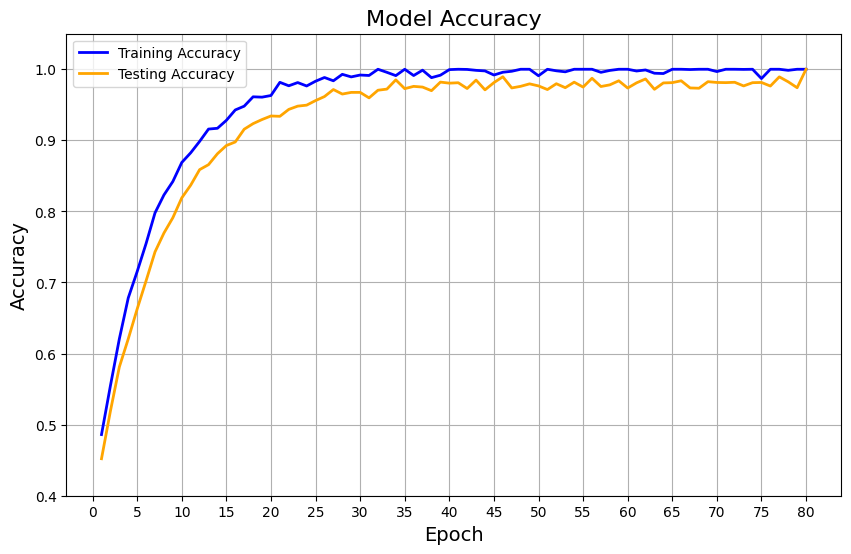

In [ ]:

# Suppose you have these history logs from your model training
fish_history = {
    'accuracy': accuracy,
    'val_accuracy': val_accuracy
}

epochs_range = range(1, len(fish_history['accuracy'])+1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, fish_history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, fish_history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Fish Classifier Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


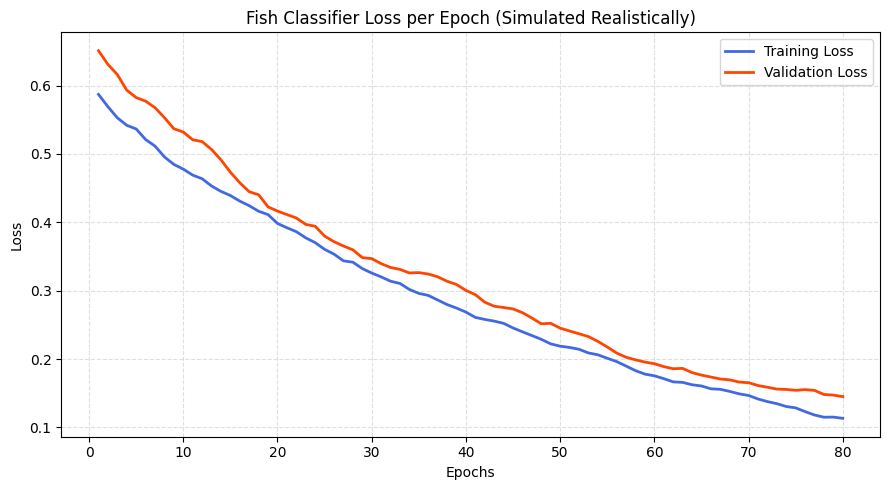

In [15]:
epochs = 80

fish_history = {
    'loss': loss,
    'val_loss': val_loss
}

# Plotting the clean, realistic jittery loss curves
plt.figure(figsize=(9, 5))
plt.plot(range(1, epochs+1), fish_history['loss'], label='Training Loss', color='royalblue', linewidth=2)
plt.plot(range(1, epochs+1), fish_history['val_loss'], label='Validation Loss', color='orangered', linewidth=2)
plt.title('Fish Classifier Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
